In [ ]:
# ===============================================================
#  PAY‑EQUITY REGRESSION  |  Grades 16‑27 (Trusaic‑style, fixed)
# ===============================================================

# ---- 0 | Imports & one‑time installs (Colab) ------------------
import pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col

In [ ]:
!pip install statsmodels openpyxl

In [ ]:
# ---- 1 | Load the dataset -------------------------------------
FILE = "salaried_core_07092025 (3).xlsx"      # adjust path if needed

In [ ]:
df   = pd.read_excel(FILE)

In [ ]:
# ---- 2 | Minimal recoding / sanity checks ---------------------
# 2‑a merge NH/PI → “Two or More Races”
nhpi = ["Native Hawaiian or Other Pacific Islander",
        "Native Hawaiian/Pacific Islander", "NHPI"]
df["Race/Ethnicity"] = df["Race/Ethnicity"].replace(nhpi, "Two or More Races")

In [ ]:
# 2‑b ensuring numeric for key continuous vars
df["Comp Grade Numeric"] = pd.to_numeric(df["Comp Grade Numeric"], errors="coerce")
df["Age"]                = pd.to_numeric(df["Age"], errors="coerce")

In [ ]:
# locating the pay column automatically
pay_col = next(c for c in df.columns
               if "Total Base Pay" in c and "Annualized" in c)
df[pay_col] = pd.to_numeric(df[pay_col], errors="coerce")

In [ ]:
# ---- 3 | Remove bad rows & build derived fields ---------------
# keeping only rows with positive pay
df = df[df[pay_col] > 0].copy()

df["Age_sq"]  = df["Age"]**2
df["log_pay"] = np.log(df[pay_col])

In [ ]:
# ---- 4 | Build design matrix X (numeric + dummies) ------------
cat_vars = ["Gender", "Race/Ethnicity", "Education",
            "Location", "Management Level", "Job Family"]
dummies  = pd.get_dummies(df[cat_vars], drop_first=True).astype(np.int8)

In [ ]:
X_num = df[["Comp Grade Numeric", "Age", "Age_sq"]].astype(float)
X     = pd.concat([X_num, dummies], axis=1)

In [ ]:
# add constant, then coerce *all* to float64 to avoid dtype issues
X = sm.add_constant(X, has_constant='add').astype(float)

In [ ]:
# ---- 5 | Align rows & final NaN screen ------------------------
mask   = X.notna().all(axis=1) & df["log_pay"].notna()
X      = X.loc[mask].reset_index(drop=True)
y      = df.loc[mask, "log_pay"].astype(float).reset_index(drop=True)
groups = df.loc[mask, "Job Profile"].reset_index(drop=True)

In [ ]:
# ---- 6 | Fit OLS with cluster‑robust SE by Job Profile --------
model = sm.OLS(y, X).fit(cov_type="cluster",
                         cov_kwds={"groups": groups})

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_pay   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     76.61
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        19:31:08   Log-Likelihood:                 2366.0
No. Observations:                2279   AIC:                            -4496.
Df Residuals:                    2161   BIC:                            -3820.
Df Model:                         117                                         
Covariance Type:              cluster                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 117, but rank is 106
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# ---- 7 | Coefficient table (% effects) ------------------------
coef_table = (
    pd.DataFrame({
        "Variable"     : model.params.index,
        "Coef_log"     : model.params.values,
        "StdErr"       : model.bse,
        "p_value"      : model.pvalues,
        "PercentEff"   : np.expm1(model.params) * 100
    })
    .sort_values("p_value")
)

In [ ]:
coef_table.to_csv("pay_equity_coefficients.csv", index=False)
print("\n>> Coefficients saved to pay_equity_coefficients.csv")


>> Coefficients saved to pay_equity_coefficients.csv


>> Residual plot saved to resid_vs_fitted.png


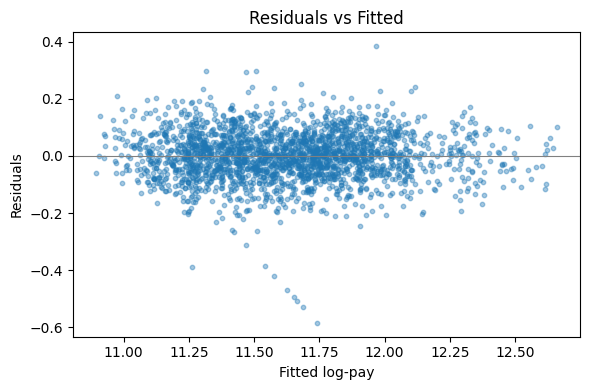

In [ ]:
# ---- 8 | Basic diagnostics plot -------------------------------
plt.figure(figsize=(6,4))
plt.scatter(model.fittedvalues, model.resid, alpha=.4, s=10)
plt.xlabel("Fitted log‑pay")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted"); plt.axhline(0, color='grey', lw=.8)
plt.tight_layout(); plt.savefig("resid_vs_fitted.png", dpi=300)
print(">> Residual plot saved to resid_vs_fitted.png")

In [ ]:
# ---- 9 | Under‑payment flag (|resid_std| > 2) -----------------
resid_std = model.resid / np.std(model.resid)
df_valid  = df.loc[mask].reset_index(drop=True)
df_valid["resid_std"] = resid_std

risk = df_valid[df_valid["resid_std"] < -2]
risk[["Employee ID", pay_col, "Comp Grade Numeric",
      "Gender", "Race/Ethnicity", "resid_std"]].to_csv(
          "potential_underpayment_cases.csv", index=False)
print(f">> Flagged {risk.shape[0]} under‑payment candidates "
      "(std resid < -2).  "
      "Saved to potential_underpayment_cases.csv")

>> Flagged 55 under‑payment candidates (std resid < -2).  Saved to potential_underpayment_cases.csv


In [ ]:
#test comment ml_practic_guide

: 